# Deepwave FWI  Test_Adam_Marm_151_401_shuffling_lr=4

### Adapted by Ricardo de Bragança in Nov 06th, 2020
from:
Janaki Vamaraju LSRTM codes and 
Deepwave FWI Example by Alan Richardson (Ausar Geophysical)

In [1]:
#Save the below parameters to output.txt file
%logstart -o -r -t -q output.txt rotate

In [2]:
# General info
# using Adam Optimization
# Shuffling sources every epoch
# SCHUSTER's MARMOUSI MODEL

# General parameters
GPU=0     # which GPU to use
plot=False # Plot Intermediate results
sigma=30   # Initial model smoothness  

# Inversion parameters
num_batches = 32
num_epochs = 1

#gamma = 300  # Does not apply, Adam uses lr (learning rate) instead of gamma
# Adam learning rate
lr = 4

# Modeling parameters
freq = 14
dx = 10
dt = 0.001
nt = 4001
num_shots = 32
num_receivers_per_shot = 200

# receiver_spacing = # computed below from ny,dx and num_receivers_per_shot

# Close the ouput.txt file with saved parameters
%logstop 

In [3]:
# Need to restart runtime before this step
import time
import torch
import numpy as np
import scipy.ndimage
import scipy.io
import matplotlib.pyplot as plt
import deepwave
import os
import csv

In [4]:
plot=True
# Load the true model
filename='Marm151_401.mat'
mat=scipy.io.loadmat(filename)['vel']
#mat = np.loadtxt('marmhard2.dat')
#mat = np.pad(mat,((10,0),(0,0)),'edge') #RB add some water layer
#RB Get model size
ny = np.size(mat,1);
nz = np.size(mat,0);
#RB compute true model mean value and width for future model normalization
max=np.max(mat)
min=np.min(mat)
med=(max+min)/2.
wid=(max-min)/2.

print('vmin=',min,'vmax=',max,'vmed=',med,'vwidth=',wid)


vmin= 1500.0 vmax= 3550.000244140625 vmed= 2525.0001220703125 vwidth= 1025.0001220703125


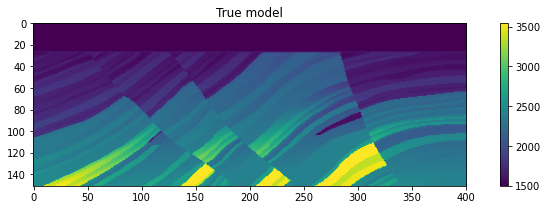

In [5]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat,vmin=min,vmax=max, aspect=1)
    plt.title('True model')
    plt.colorbar()

In [6]:
#RB Open file to write results
f = open('marmsm_Mod8_log.txt','a+')
writer = csv.writer(f)

#RB Write header
fields=['Epoch','it','loss.item','epoch_loss','it_lap','epoch_lap']
writer.writerow(fields)
f.flush()
os.fsync(f)

In [7]:
# Specify which GPU to use (in multi GPU machines)
torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
GPU_string='cuda:'+str(GPU)
device = torch.device(GPU_string)

In [8]:
# Set parameters
##freq = 14
##dx = 10
##dt = 0.001

#RB nt = int(2 / dt) # 2s
#nt = int(0.9 * int(np.sqrt((nz*dx)**2 + (ny*dx)**2) / 2000 / dt))
#nt =       3 * int(np.sqrt((nz*dx)**2 + (ny*dx)**2) / 2000 / dt)
##nt = 4001

num_dims = 2
#num_shots = 32
num_sources_per_shot = 1
#num_receivers_per_shot = 200

#RB source_spacing = 25.0
#RB receiver_spacing = 10.0
source_spacing = ny * dx / num_shots
receiver_spacing = ny * dx / num_receivers_per_shot
#receiver_spacing = 8.

print('ny=',ny,'nz=',nz,'nt=',nt,'dx=',dx,'freq=',freq)
print('shots=',num_shots,'recs/shot=',num_receivers_per_shot, \
      'ds=',source_spacing,'dr=',receiver_spacing)


ny= 401 nz= 151 nt= 4001 dx= 10 freq= 14
shots= 32 recs/shot= 200 ds= 125.3125 dr= 20.05


In [9]:
# Create arrays containing the source and receiver locations
# x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
# x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing
#x_s[:, 0, 0] = 100. #RB Set source depth

x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

#RB Shuffle shot coordinates
###idx = torch.randperm(num_shots)
###x_s = x_s.view(-1,2)[idx].view(x_s.size())

#RB Set Receiver depth
#x_r[0, :, 0] = 100.
#x_r[:, :, 0] = x_r[0, :, 0].repeat(num_shots, 1)

# Create true source amplitudes [nt, num_shots, num_sources_per_shot]
# I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
# can use whatever Tensor you want as the source amplitude.
source_amplitudes_true = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))

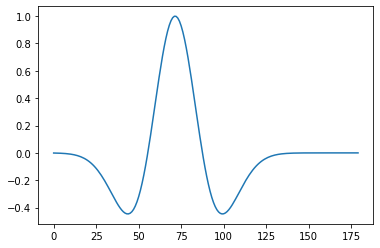

In [10]:
plt.plot(source_amplitudes_true[:180,0,0])

In [11]:
#RB Generate a cte velocy model (with water velocity)
mat2 = np.ones((nz,ny),np.float32)*1500.
mat2[nz-1,int(ny/2)]=max  # put a pixel with true upper velocity to fix a propagator problem


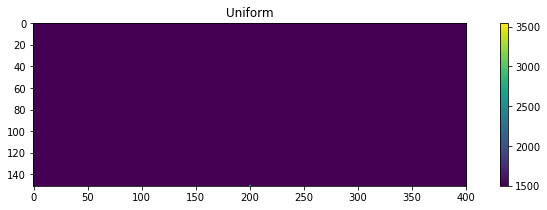

In [12]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat2,vmin=min,vmax=max, aspect=1)
    plt.title('Uniform')
    plt.colorbar()

In [13]:
#RB Convert models to PyTorch Tensors
model_true = torch.Tensor(mat) # Convert to a PyTorch Tensor
model_cte = torch.Tensor(mat2) # Convert to a PyTorch Tensor

In [14]:
###### Create 'true' data 
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

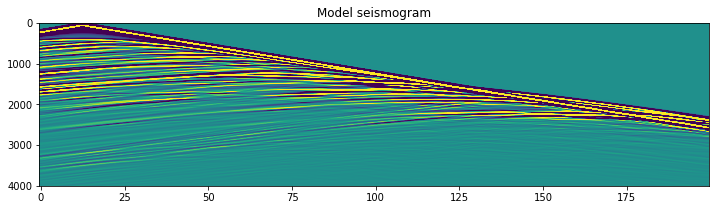

In [15]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_all[:,2].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
    plt.title('Model seismogram')

In [16]:
# Create direct arrivals data
prop2 = deepwave.scalar.Propagator({'vp': model_cte.to(device)}, dx)
receiver_amplitudes_cte = prop2(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

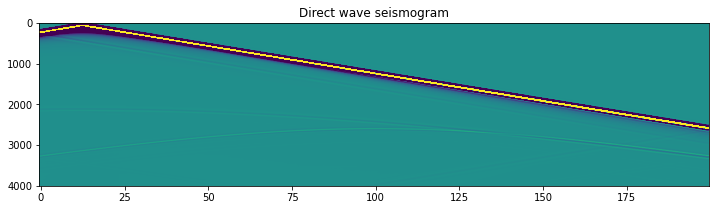

In [17]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_cte[:,2].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
    plt.title('Direct wave seismogram')

In [18]:
# Exclude direct waves from true data (they don't bring info from subsurface)
receiver_amplitudes_true = receiver_amplitudes_all - receiver_amplitudes_cte

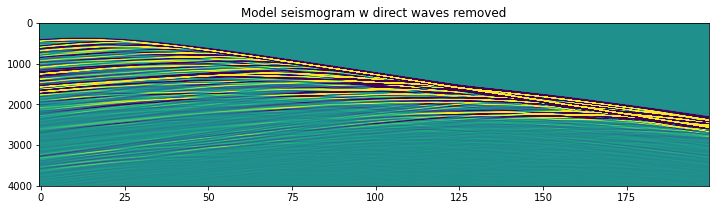

In [19]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_true[:,2].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
    plt.title('Model seismogram w direct waves removed')

In [20]:
# Verify that the returned receiver amplitudes have shape
# [nt, num_shots, num_receivers_per_shot]
receiver_amplitudes_true.shape

torch.Size([4001, 32, 200])

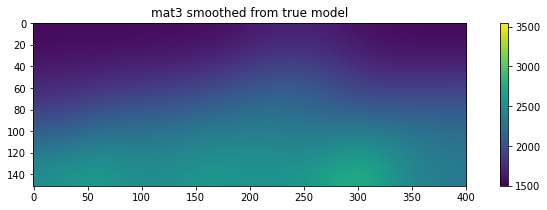

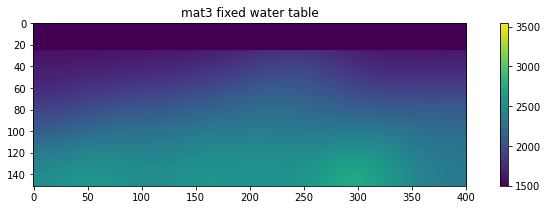

In [21]:
#RB Create a smoothed model

#RB start with true model
mat3 = np.copy(mat)
#RB Filter image heavly
mat3 = scipy.ndimage.gaussian_filter(mat3,sigma=sigma) #10,50  #5%,10%
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat3,vmin=min,vmax=max)
    plt.title('mat3 smoothed from true model')
    plt.colorbar()
    
#RB Force water table to be 1500 m/s (avoid imperfect direct wav removal)    
mat3[0:26,:]=1500.

#RB Plot model
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat3,vmin=min,vmax=max)
    plt.title('mat3 fixed water table')
    plt.colorbar()

#RB We may want to smooth the water table transition
#RB but I think it's a bad idea (not tested)
# mat3 = scipy.ndimage.gaussian_filter(mat3,sigma=4)

#RB Optionally we may import a initial model from file
#filename='Marm151_401_smooth.mat'
#mat3=scipy.io.loadmat(filename)['vel0']

#RB Ensure that the initial model has the same range of the true model by
#RB forcing one of its slowest pixel to have the true's model lower velocity and
#RB forcing one of its fastest pixel to have the true's model upper velocity
#RB find max & min values of mat3
smin=np.min(mat3)
smax=np.max(mat3)
indmin = np.where(mat3==smin)
indmax = np.where(mat3==smax)
# Take first pixel with minimum velocity and force it to true's model minimum velocity
mat3[indmin[0][0],indmin[1][0]]=min
# Take first pixel with maximum velocity and force it to true's model maximum velocity
mat3[indmax[0][0],indmax[1][0]]=max

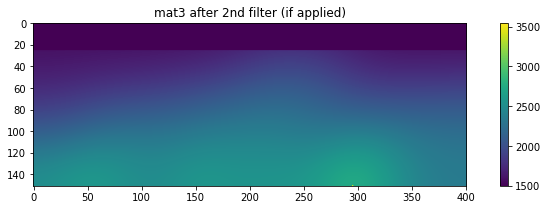

In [22]:
#RB Plot the initial model
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat3,vmin=min,vmax=max)
    plt.title('mat3 after 2nd filter (if applied)')
    plt.colorbar()

In [23]:
#RB Check if it have the same max and min velocities of true model
smin=np.min(mat3)
smax=np.max(mat3)
print(smax,smin)
print('should be:')
print(max,min)

3550.000244140625 1500.0
should be:
3550.000244140625 1500.0


In [24]:
#RB Save true and initial model to file
filename='Marm_Mod8_models.mat'
scipy.io.savemat(filename, mdict={'True':mat, 'Init':mat3}) 

In [25]:
#RB Normalize initial model to (-1,1) range
#model_init = (mat3-med)/wid
#RB_No_normalization
model_init = mat3

In [26]:
#if plot==True:
    #plt.figure(figsize=(12, 3))
    #plt.imshow(model_init,vmin=-1,vmax=1)
    #plt.title('model_init in (-1,+1) range for inversion')
    #plt.colorbar()

In [27]:
# Convert to Pytorch tensor
#model_init = torch.from_numpy(np.float32(model_init))
model_init = torch.Tensor(model_init)

# Make a copy so at the end we can see how far we came from the initial model
model = model_init.clone()
model = model.to(device)
model.requires_grad = True

In [28]:
#RB AS I am not inverting for source, I could just do
#RB source_amplitudes = source_amplitudes_true.clone().to(device)
#RB instead of all code below

# Create initial guess source amplitude for inversion
# I will assume that the true source amplitude is the same for every shot
# so I will just create one source amplitude, and PyTorch will backpropagate
# updates to it from every shot
source_amplitudes_init = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1))
source_amplitudes = source_amplitudes_init.clone()
source_amplitudes = source_amplitudes.to(device)
#source_amplitudes.requires_grad_(); # Alternative way of requiring gradient

In [29]:
# To demonstrate chaining operations, during the inversion I will normalise the
# predicted receiver amplitudes so that each trace has a maximum value of 1.
# This will be compared (in the cost function) with the true data that has been
# similarly scaled. I apply that scaling to the true data now.
# This sort of scaling might be useful for real data where the absolute
# amplitudes are often not meaningful.
rcv_amps_true_max, _ = receiver_amplitudes_true.max(dim=0, keepdim=True)
rcv_amps_true_norm = receiver_amplitudes_true / rcv_amps_true_max

In [30]:
# Set-up inversion
#gamma = 300
criterion = torch.nn.MSELoss()
#RB optimizer = torch.optim.SGD([{'params': model }],lr = 100000., momentum=0)
optimizer = torch.optim.Adam([{'params': [model], 'lr': lr}])

Processing Epoch: 0
torch.Size([4001, 32, 200])
shape of predicted
torch.Size([4001, 1, 200])
shape of predicted
torch.Size([4001, 1, 200])
shape of predicted
torch.Size([4001, 1, 200])
shape of predicted
torch.Size([4001, 1, 200])
shape of predicted
torch.Size([4001, 1, 200])
shape of predicted
torch.Size([4001, 1, 200])
shape of predicted
torch.Size([4001, 1, 200])
shape of predicted
torch.Size([4001, 1, 200])
shape of predicted
torch.Size([4001, 1, 200])
shape of predicted
torch.Size([4001, 1, 200])
shape of predicted
torch.Size([4001, 1, 200])
shape of predicted
torch.Size([4001, 1, 200])
shape of predicted
torch.Size([4001, 1, 200])
shape of predicted
torch.Size([4001, 1, 200])
shape of predicted
torch.Size([4001, 1, 200])
shape of predicted
torch.Size([4001, 1, 200])
shape of predicted
torch.Size([4001, 1, 200])
shape of predicted
torch.Size([4001, 1, 200])
shape of predicted
torch.Size([4001, 1, 200])
shape of predicted
torch.Size([4001, 1, 200])
shape of predicted
torch.Size([4

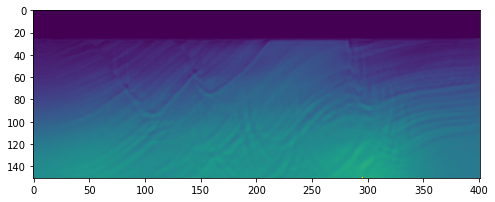

Runtime: 6.345381498336792


In [33]:
#%%capture cap --no-stderr 
# The line above captures the output of this cell to the variable cap

# Iterative inversion loop
t_start = time.time()

##num_batches = 32 # split data into batches for speed and reduced memory use
num_shots_per_batch = int(num_shots / num_batches)
##num_epochs = 1000 # Pass through the entire dataset 30 times

#vmin, vmax = np.percentile(model_true.numpy(), [2,98]) # For plotting
vmin = min
vmax = max
#vmin=-1
#vmax= 1
# Temperature coefficient
##Tk =50



for epoch in range(num_epochs):
    ep_start=time.time()
    print('Processing Epoch:',epoch)
    epoch_loss = 0.0
    
    #RB Shuffle shot coordinates
    idx = torch.randperm(num_shots)
    x_s = x_s.view(-1,2)[idx].view(x_s.size())
    #RB Shuffle true's seismograms sources with same random values
    rcv_amps_true_norm = rcv_amps_true_norm[:,idx,:]
    #RB Shuffle direct wave seismograms sources with the same random values
    receiver_amplitudes_cte = receiver_amplitudes_cte[:,idx,:]
    print(np.shape(rcv_amps_true_norm))
    
    for it in range(num_batches):
        it_start = time.time()
        ###print('    Processing Batch:',it,' of', num_batches)
        
        optimizer.zero_grad()
        #if model.grad is not None:
        #    model.grad.data.zero_()
        #    print('Preexinting Model Grad zeroed')
            
        #RB Denormalize model to perform forward propagation
        #model2=model*wid+med
        #RB or no denormalization if using Adam
        model2=model.clone()
        #RB Clamp the model within acceptable range
        model2=torch.clamp(model,min=min,max=max)        
        
        #RB Make sure the model have same range of velocities of true's model (fix propag issue)
        #RB forcing one of its slowest pixel to have the true's model lower velocity and
        #RB forcing one of its fastest pixel to have the true's model upper velocity       
        #RB find max & min values of model2
        smin=torch.min(model2)
        smax=torch.max(model2)
        indmin = torch.where(model2==smin)
        indmax = torch.where(model2==smax)
        # Take first pixel with minimum velocity and force it to true's model minimum velocity
        model2[indmin[0][0],indmin[1][0]]=min
        # Take first pixel with maximum velocity and force it to true's model maximum velocity
        model2[indmax[0][0],indmax[1][0]]=max
        
        prop3 = deepwave.scalar.Propagator({'vp': model2}, dx)
        batch_src_amps = source_amplitudes.repeat(1, num_shots_per_batch, 1)
        batch_rcv_amps_true = rcv_amps_true_norm[:,it::num_batches].to(device)
        
        #RB Alternative normalization (normalizing to dTrue amplitude range)
        #batch_rcv_amps_true_max, _ = batch_rcv_amps_true.max(dim=0, keepdim=True)
        
        #RB get the seismogram of the direct wave for current batch
        batch_rcv_amps_cte = receiver_amplitudes_cte[:,it::num_batches].to(device)
        
        #RB get the current batch source & receiver coordinates
        batch_x_s = x_s[it::num_batches].to(device)
        batch_x_r = x_r[it::num_batches].to(device)

        #print('FWD Propag')
        #timer_a = time.time()
        
        batch_rcv_amps_pred = prop3(batch_src_amps, batch_x_s, batch_x_r, dt)
        
        #RB Subtract direct wave on all seismograms of current batch
        batch_rcv_amps_pred = batch_rcv_amps_pred - batch_rcv_amps_cte
        
        #RB Normalize
        batch_rcv_amps_pred_max, _ = batch_rcv_amps_pred.max(dim=0, keepdim=True)
        batch_rcv_amps_pred_norm = batch_rcv_amps_pred / batch_rcv_amps_pred_max
        
        print("shape of predicted")
        print(np.shape(batch_rcv_amps_pred_norm))
        #RB Alternative normalization
        #batch_rcv_amps_pred_norm = batch_rcv_amps_pred / batch_rcv_amps_true_max
        
        #RB ATTENTION: this line will be executed BEFORE GPU finish FWD computation
        #RB Measured lab will be much shorter that real
        #timer_b = time.time()
        #print('Lap=',timer_b-timer_a)
        
        #print('Loss evaluation')
        
        #RB Prints for DEBUG purpose
        #plt.imshow(batch_rcv_amps_true[:,0,:].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
        #plt.colorbar()
        #plt.show()
        #plt.imshow(batch_rcv_amps_cte[:,0,:].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
        #plt.colorbar()
        #plt.show()
        #plt.imshow(batch_rcv_amps_pred_norm[:,0,:].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
        #plt.colorbar()
        #plt.show()

        #plt.imshow(batch_rcv_amps_true[:,0,:].cpu().detach().numpy(), aspect='auto')
        #plt.colorbar()
        #plt.show()
        #plt.imshow(batch_rcv_amps_cte[:,0,:].cpu().detach().numpy(), aspect='auto')
        #plt.colorbar()
        #plt.show()
        #plt.imshow(batch_rcv_amps_pred_norm[:,0,:].cpu().detach().numpy(), aspect='auto')
        #plt.colorbar()
        #plt.show()        
        
        loss = criterion(batch_rcv_amps_pred_norm, batch_rcv_amps_true)            
        epoch_loss += loss.item()
        
        #timer_a = time.time()
        #print('Lap=',timer_a-timer_b)
        
        
        #print('Backpropagation')
    
        loss.backward()
        model.grad[0:26,:]=0.
        
        
        #timer_b = time.time()
        #print('Lap=',timer_b-timer_a)
        
        #RB Hill climbing factor computation
        #low = 1-2*np.exp(-epoch/Tk)
        #alpha = np.random.uniform(low=low,high=1)
        #alpha = 1.
        
        #print('Model update')
        #with torch.no_grad():                
            #RB update model
        #    model =  model - torch.tanh(alpha*gamma*model.grad)                
        #model.requires_grad = True        
        optimizer.step()
        
        
        # Clamp model to acceptable range
        #with torch.no_grad():
        #    model=torch.clamp(model,min=min,max=max)
        #model.requires_grad = True
        
        it_end = time.time()
        #print('Lap=',it_end-timer_b)
        
        
    #RB Write variables to file at each epoch
    fields=[epoch,it,loss.item(),epoch_loss, it_end - it_start,it_end - ep_start]
    writer.writerow(fields)
    f.flush()
    os.fsync(f)
    
    print('Epoch:', epoch, 'Loss: ', epoch_loss)
    img = np.array(model.cpu().detach().numpy())

    filename='Marmsm_Mod8_epoch_'+str(epoch)+'.mat'
    scipy.io.savemat(filename, mdict={'Model': img})
       
    if epoch % 50 == 0:
        
        if plot==True:
            plt.figure(figsize=(8, 4))
            plt.imshow(model.cpu().detach().numpy(), vmin=vmin, vmax=vmax,cmap='viridis')
            plt.show() 
    
    epoch+=1

t_end = time.time()
print('Runtime:', t_end - t_start)

In [ ]:
# Plot initial, inverted, and true models
if plot==True:
    figsize = (12, 6)
    plt.figure(figsize=figsize)
    plt.imshow(model_init.numpy(), vmin=vmin, vmax=vmax, cmap='viridis')
    plt.title('Initial');
    plt.figure(figsize=figsize)
    plt.imshow(model.cpu().detach().numpy(), vmin=vmin, vmax=vmax, cmap='viridis')
    plt.title('Inverted');
    plt.figure(figsize=figsize)
    plt.imshow(model_true.numpy(), vmin=min, vmax=max, cmap='viridis')
    plt.title('True');

In [ ]:
%%capture cap2 --no-stderr
# The line above captures the output of this cell to the variable cap2

%whos

In [ ]:
# Append cell's captured outputs to file output.txt
with open('output.txt', 'a') as f:
    f.write(cap.stdout)
    f.write(cap2.stdout)